# Modelos de regresión logística

Basado en el capítulo 4 de **Introducion to statistical learning with R**, de Gareth James, Daniea Witten, Trevor Hastie y Robert Tibshirani. Los ejemplos presentados en R en el libro fueron llevados a Python y completados.

El dataset que vamos a analizar contiene los registros del histórico de las personas a las que se les ha otorgado un crédito financiero y pudieron pagarlo o no.
La idea es poder predecir en un futuro, a partir de las variables independientes que aspirantes a un crédito tienen mas o menos riesgo de pagar.

Las variables de la hoja de datos son las siguientes:
- ID: El ID del cliente en el banco. Numérico, debe ser positivo y único
- PudoPagar: Indica si el cliente ha podido pagar el crédito sin problemas (1) o no (0). Variable categórica binaria
- Estudiante: Indica si el cliente es estudiante (Si) o no lo es (No). Variable categórica binaria
- Deuda: Indica la cantidad del crédito que aún adeuda el cliente. Deben ser valores numéricos positivos o nulos
- Ingresos: Indica el salario o demás ingresos de los que disponga. Deben ser valores numéricos positivos o nulos


## Entendimiento y preparación de los datos

Realice un análisis exploratorio de los datos verificando la calidad de los mismos. Utilice gráficos para poder identificar posibles problemas.



In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib as mpl
import matplotlib.pyplot as plt #gráficos
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import KFold, cross_val_score #protocolo de evaluación
from sklearn import metrics
from sklearn.preprocessing import scale 
import seaborn as sns

Cargamos los datos, que están en el mismo directorio que el notebook.

In [2]:
data = pd.read_csv('02_creditos.csv', sep=';')
data.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [4]:
data.describe(include="all")

,default,student,balance,income
count,10000,10000,10000.000000,10000.000000
unique,2,2,NaN,NaN
top,No,No,NaN,NaN
freq,9667,7056,NaN,NaN
mean,NaN,NaN,835.374886,33516.981876
std,NaN,NaN,483.714985,13336.639563
min,NaN,NaN,0.000000,771.967729
25%,NaN,NaN,481.731105,21340.462903
50%,NaN,NaN,823.636973,34552.644802
75%,NaN,NaN,1166.308386,43807.729272


In [5]:
data.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

La variable independiente student debe convertise en variable numérica. Vamos a utilizar el método factorize, que devuelve dos objetos: un array de labels y un array con los valores únicos que se encontraron y cuyas posiciones son los nuevos valores de los factores.

In [6]:
data.student.factorize()

(array([0, 1, 0, ..., 0, 0, 1], dtype=int64),
 Index(['No', 'Yes'], dtype='object'))

Solo nos interesamos en el primer array, que lo vamos a utilizar para remplazar los datos del dataframe

In [7]:
data['default2'] = data.default.factorize()[0]
data['student2'] = data.student.factorize()[0]
data.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


96.67

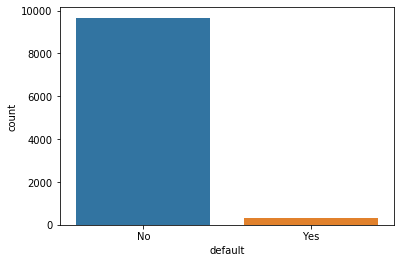

In [8]:
### Baseline
ax = sns.countplot(x="default", data=data)
data.default[data.default=="No"].aggregate('count') / data.shape[0] * 100

Vamos a analizar los valores gráficamente.
Para que sean más lisibles y, dado que hay un gran desbalanceo entre los datos sin default y los datos con default, vamos a crear un nuevo Dataframe para poder visualizar los datos, en donde incluiremos todos los datos con default y una muestra con un porcentaje (15%) de los datos sin default.

In [9]:
# Solo consideramos una muestra con una parte de los clientes que no tienen default
data_no = data[data.default2 == 0].sample(frac=0.15)

# Como son pocos, tomamos todos los datos de los clientes que si tienen default
data_yes = data[data.default2 == 1]
data_ = data_no.append(data_yes)
data.describe(include="all")

,default,student,balance,income,default2,student2
count,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000
unique,2,2,NaN,NaN,NaN,NaN
top,No,No,NaN,NaN,NaN,NaN
freq,9667,7056,NaN,NaN,NaN,NaN
mean,NaN,NaN,835.374886,33516.981876,0.033300,0.294400
std,NaN,NaN,483.714985,13336.639563,0.179428,0.455795
min,NaN,NaN,0.000000,771.967729,0.000000,0.000000
25%,NaN,NaN,481.731105,21340.462903,0.000000,0.000000
50%,NaN,NaN,823.636973,34552.644802,0.000000,0.000000
75%,NaN,NaN,1166.308386,43807.729272,0.000000,1.000000


Creamos 3 plots:
- un scatterplot con las variables income y balance en los ejes y el color dado por la categoría del default
- un boxplot con las distribuciones de del income para las categorías con y sin default
- un boxplot con las distribuciones de del balance para las categorías con y sin default

Vamos a ignorar los warnings que no son importantes para lo que vamos a hacer

In [10]:
import warnings
warnings.filterwarnings('ignore')

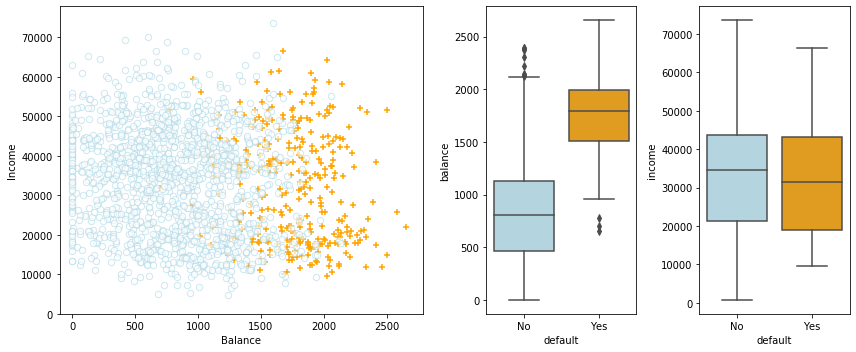

In [11]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Plot de balance x income
ax1.scatter(data_[data_.default == 'Yes'].balance, data_[data_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(data_[data_.default == 'No'].balance, data_[data_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)
ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

# 2 Boxplots
c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=data, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=data, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

Podemos ver que la variable *balance* es bastante discriminante con respecto a la variable dependiente.

## Modelamiento: regresión logística vs. regresión lineal

### Variable independiente: balance

Vamos a analizar la relación estrecha entre la variable independiente *balance* con la dependiente *default* para ilustrar los problemas que tendría el utilizar la regresión linear para tareas de clasificación, al mismo tiempo que comparamos ese modelo con el de la regresión logística.

Primero preparamos los datos en dos variables, una matriz de una sola columna para la variable predictiva y un array con los valores de la variable objetivo.

In [12]:
X = data.balance.values.reshape(-1,1) #Una columna, con las filas que se necesiten
X.shape

(10000, 1)

In [13]:
y = data.default2
y.shape

(10000,)

Con el propósito de poder visualizar el resultado de los modelos de clasificación, creamos un array con todos los valores enteros entre el más pequeño y el más grande de la variable indepediente balance y predecimos el valor de la variable dependiente de estos valores.

In [14]:
X_plot = np.arange(data.balance.min(), data.balance.max()).reshape(-1,1)
print("El rango de la variable balance es [{}, {}]".format(data.balance.min(), data.balance.max()))

El rango de la variable balance es [0.0, 2654.32257628018]


In [15]:
X_plot[0:5]

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.]])

Creamos el modelo de LogReg, predecimos las probabilidades para todos los valores en el rango de la variable predictiva.

In [16]:
clf = LogisticRegression()
clf.fit(X,y)
prob = clf.predict_proba(X_plot)
prob

array([[9.99922493e-01, 7.75069411e-05],
       [9.99922122e-01, 7.78784751e-05],
       [9.99921748e-01, 7.82517900e-05],
       ...,
       [3.84915469e-02, 9.61508453e-01],
       [3.83149378e-02, 9.61685062e-01],
       [3.81391069e-02, 9.61860893e-01]])

Ploteamos el resultado de la regresión lineal en el plot izquierdo y de la regresión logística en el plot de la derecha.

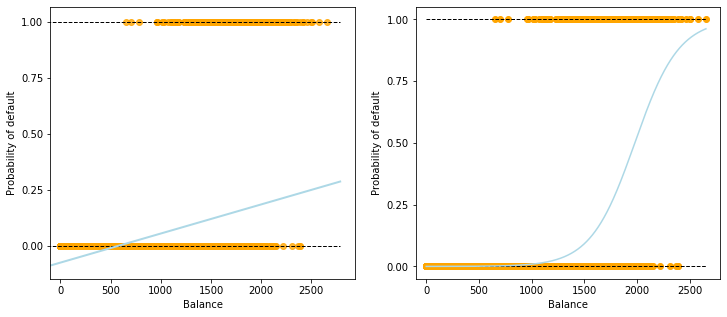

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Izquierda: plot de regresión lineal: se le dan los datos del eje x, del eje y, el orden polinómico
# el nivel de confianza para un intervalo de confianza (ci), parámetros para el plot de scatter,
# y parámetros para el plot lineal
sns.regplot(data.balance, data.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)

# Derecha: plot de regresión logística: un scatterplot con los valores del balance y del default (0/1),
# y un plot con las probabilidades resultado de la regresión logística.
ax2.scatter(X, y, color='orange')
ax2.plot(X_plot, prob[:,1], color='lightblue')

# Se agregan las lineas de los valores 0 y 1 y los títulos de los ejes
for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

Los resultados de la regresión logística con la variable *balance* nos dan:

In [18]:
clf = LogisticRegression()

X = data.balance.values.reshape(-1,1)
clf.fit(X,y)
print(clf)
print('clases: ',clf.classes_)
print('coeficientes: ',clf.coef_)
print('intercepto :', clf.intercept_)
y_pred = clf.predict(X)
cm= metrics.confusion_matrix(y, y_pred)
print(cm)
print("Exactitud: ", metrics.accuracy_score(y, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y, y_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
clases:  [0 1]
coeficientes:  [[0.00478248]]
intercepto : [-9.46506555]
[[9639   28]
 [ 246   87]]
Exactitud:  0.9726
Kappa    :  0.37775496717316803


Al igual que con la regresión lineal, scikit-learn no facilita los valores-p de la significancia de los coeficientes, por lo que utilizaremos **statsmodels**

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = sm.add_constant(data.balance)
est = sm.Logit(y.ravel(), X).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


Encontramos que el coeficiente de *balance* positvo, y tiene un valor-p inferior a un nivel de significancia del 5% o del 1%, por lo que podemos decir que la relación entre balance y default es significativa.

### Variable independiente: student

In [20]:
X = sm.add_constant(data.student2)
est = sm.Logit(y.ravel(), X).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


Vemos que la variable *student* tiene un coeficiente positivo, lo que significa que los estudiantes son más propensos a tener default que los no estudiantes, y su valor-p es significativo.

### Variables independientes: balance, income y student (regresión logística múltiple)

In [21]:
X = sm.add_constant(data[['balance', 'income', 'student2']])
est = smf.Logit(y, X).fit()
est.summary2().tables[1]

AttributeError: module 'statsmodels.formula.api' has no attribute 'Logit'

En el modelo de regresión logística múltiple nos da que income no es significativa (valor-p del 71%), aunque las otras dos si.
En este modelo múltiple, el coeficiente de *student* nos dice que los estudiantes son menos propensos al default que los no estudiantes (coeficiente negativo). 
En la regresión logística que solo consideraba *student* encontrabamos que la relación  era contraria.

Esto se puede explicar por la relación entre *student* y *balance* (no incluimos *income*, al no ser significativa). 
Vamos a analizar por separado la subpoblación estudiante y la no estudiante para tratar de entender esta relación entre *student* y *default* dado la presencia de *balance*.

In [ ]:
# Dividimos los datos entre los estudiantes y los no estudiantes.
X_stud = data[data.student == 'Yes'].balance.values.reshape(data[data.student == 'Yes'].balance.size,1) 
y_stud = data[data.student == 'Yes'].default2
X_nostud = data[data.student == 'No'].balance.values.reshape(data[data.student == 'No'].balance.size,1) 
y_nostud = data[data.student == 'No'].default2

Aprendemos los dos modelos de regresión para los dos datasets, solo considerando *balance* como variable independiente.
Al igual que anteriormente, evaluamos para el rango de valores posibles de la variable *balance*.

In [ ]:
#Aprendizaje de los modelos
logreg_stud   = LogisticRegression()
logreg_nostud = LogisticRegression()
logreg_stud.fit  (  X_stud, y_stud  )
logreg_nostud.fit(X_nostud, y_nostud)

# Evaluación de los modelos
X_plot = np.arange(data.balance.min(), data.balance.max()).reshape(-1,1)
prob_stud = logreg_stud.predict_proba(X_plot)
prob_nostud = logreg_nostud.predict_proba(X_plot)

In [ ]:
y_pred_stud = clf.predict(X_stud)
cm= metrics.confusion_matrix(y_stud, y_pred_stud)
print(cm)

data.default[data.default=="No"].aggregate('count') / data.shape[0] * 100
print("Baseline: ", (len(y_stud)-np.count_nonzero(y_stud)) / len(y_stud))
print("Exactitud: ", metrics.accuracy_score(y_stud, y_pred_stud))
print("Kappa    : ", metrics.cohen_kappa_score(y_stud, y_pred_stud))

In [ ]:
y_pred_nostud = clf.predict(X_nostud)
cm= metrics.confusion_matrix(y_nostud, y_pred_nostud)
print(cm)
print("Baseline: ", (len(y_nostud)-np.count_nonzero(y_nostud)) / len(y_nostud))
print("Exactitud: ", metrics.accuracy_score(y_nostud, y_pred_nostud))
print("Kappa    : ", metrics.cohen_kappa_score(y_nostud, y_pred_nostud))

In [ ]:
data.groupby(['student','default']).size().unstack('student')

Creamos dos plots para poder entender la relación entre *student* y *balance*

In [ ]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_plot, pd.DataFrame(prob_stud)[1], color='orange', label='Estudiantes')
ax1.plot(X_plot, pd.DataFrame(prob_nostud)[1], color='lightblue', label='No estudiantes')
ax1.hlines(127/2817, colors='orange', label='Estudiantes, global',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='No estudiantes, global',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default')
ax1.set_xlabel('Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=data, orient='v', ax=ax2,  palette=c_palette);

Vemos a la derecha que los estudiantes tienen valores mayores de *balance* que los no estudiantes. Como las distribuciones de *balance* para estudiantes y no estudiantes son diferentes, podemos decir que hay una correlación.

En el gráfico de la izquierda vemos las líneas horizontales punteadas de probabilidad globales de *default* (sin considerar el balance), con la de los estudiantes por encima de la de los no estudiantes.
Sin embargo, cuando consideramos la correlación de *student* con *balance*, encontramos que a mayores valores de balance, la probabilidad de default es mayor para los no estudiantes que para los estudiantes.

Este caso ilustra las sutilezas asociadas a las regresiones realizadas con una sola variable, cuando otros predictores pueden ser también relevantes. También muestra los posibles efectos de las correlaciones entre predictores. Este fenómeno se llama **"confounding"**.